# Flow Field in PFR

In [1]:
using LinearAlgebra, LinearSolve, Plots, LaTeXStrings

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Module SciMLBase with build ID ffffffff-ffff-ffff-0005-0f35fc09ba7a is missing from the cache.
│ This may mean SciMLBase [0bca4576-84f4-4d90-8ffe-ffa030f20462] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541
┌ Warning: Module LinearSolve with build ID ffffffff-ffff-ffff-0005-0f34204245ed is missing from the cache.
│ This may mean LinearSolve [7ed4a6bd-45f5-4d41-b270-4a48e9bafcae] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2541


In [36]:
# Problem specs
Nz = 100
L = 10.
dz = L / (Nz+0.5)
v_in = 0.1
p_out = 1e5
Mw = 1e-3
mu = 2e-5
dp = 3e-2
T = 300.
R = 8.314
eps_b = 0.5
function calc_f(eps_b, rho, v, dp, mu)
    Rep = (rho*abs(v+1e-10)*dp) / mu
    f = 6.8 * (((1-eps_b)^1.2) / (eps_b^3)) * Rep^(-0.2)
    return f
end
rho_out = p_out * Mw / (R * T)

t = 0.
tf = 10.
dt = 0.01
t_vec = range(t, tf, 7)
vzt_mat = zeros((Nz+1, length(t_vec)))
pzt_mat = copy(vzt_mat)
vzt_mat[1, :] .= v_in
pzt_mat[end, :] .= p_out;

In [37]:
# Initial condition and initial guess
v0 = zeros(Nz)
p0 = ones(Nz) * p_out
vzt_mat[2:end, 1] = v0
pzt_mat[1:end-1, 1] = p0
p_s = range(2*p_out, p_out, Nz)

i_t = 2
v = copy(v0)
p = copy(p0)
atol = 1e-8
jmax = 100
alpha_v_s = 0.5
alpha_p = 0.8

0.8

In [ ]:
# Solving the problem

while t<tf

    # Updating previous time step
    v0 = copy(v)
    p0 = copy(p)
    rho0 = @. p0 * Mw / (R * T)
    rho0_out = p_out * Mw / (R * T)
    rho0_m = @. (rho0[2:end] + rho0[1:end-1]) / 2.0
    append!(rho0_m, (rho0[end]+rho0_out)/2.0)

    j = 0
    p_s = copy(p0)
    vj0 = copy(v)

    while j < jmax

        # Calculating intermediates
        rho_s = @. p_s * Mw / (R * T)
        rho_out = p_out * Mw / (R * T)
        rho_m = @. (rho_s[2:end] + rho_s[1:end-1]) / 2.0
        append!(rho_m, (rho_s[end]+rho_out)/2.0)
        F_m = @. 1/(eps_b^2) * 0.5*(vj0[2:end] + vj0[1:end-1]) * rho_s[2:end]
        insert!(F_m, 1, 1/(eps_b^2) * 0.5*(vj0[1] + v_in) * rho_s[1])
        F_out = F_m[end] - 0.5*dz/dt * 1/(eps_b^2) * (rho_out - rho0_out)

        aE = zeros(Nz)
        aW = zeros(Nz)
        aP_v = zeros(Nz)
        b = zeros(Nz)

        # Setting Coefficients
        ## Lower BC
        z = 1
        f = calc_f(eps_b, rho_m[z], vj0[z], dp, mu)
        S_P = - f * rho_m[z] * abs(vj0[z]) / dp
        aW[z] = maximum([F_m[z], 0.0])
        aE[z] = maximum([-F_m[z+1], 0.0])
        aP_v[z] = aE[z] + aW[z] + (F_m[z+1] - F_m[z]) + (rho_m[z]*dz)/(eps_b*dt) - S_P*dz
        aP0 = (rho0_m[z] * dz) / (eps_b * dt)
        b[z] = aP0 * v0[z] + (p_s[z] - p_s[z+1]) + aW[1] * v_in  

        ## Midpoints
        for z in 2:Nz-1
            f = calc_f(eps_b, rho_m[z], vj0[z], dp, mu)
            S_P = - f * rho_m[z] * abs(vj0[z]) / dp
            aW[z] = maximum([F_m[z], 0.0])
            aE[z] = maximum([-F_m[z+1], 0.0])
            aP_v[z] = aE[z] + aW[z] + (F_m[z+1] - F_m[z]) + (rho_m[z]*dz)/(eps_b*dt) - S_P*dz
            aP0 = (rho0_m[z] * dz) / (eps_b * dt)
            b[z] = aP0 * v0[z] + (p_s[z] - p_s[z+1])
        end                                            

        ## Upper BC
        z = Nz
        f = calc_f(eps_b, rho_m[z], vj0[z], dp, mu)
        S_P = - f * rho_m[z] * abs(vj0[z]) / dp
        aW[z] = maximum([F_m[z], 0.0])
        aE[z] = maximum([-F_out, 0.0])
        aP_v[z] = aE[z] + aW[z] + (F_out - F_m[z]) + (rho_m[z]*dz)/(eps_b*dt) - S_P*dz
        aP0 = (rho0_m[z] * dz) / (eps_b * dt)
        b[z] = aP0 * v0[z] + (p_s[z] - p_out)

        # Assemble and solve
        A = Tridiagonal(-aW[2:end], aP_v, -aE[1:end-1])
        prob = LinearProblem(A, b)
        sol = solve(prob)
        v_s = @. (1-alpha_v_s) * v + alpha_v_s * sol.u

        aE = zeros(Nz)
        aW = zeros(Nz)
        aP = zeros(Nz)
        b = zeros(Nz)

        # Setting coefficients
        ## Upper BC
        z = 1
        aE[z] = rho_m[z] / aP_v[z]
        aW[z] = 0.0
        aP[z] = aE[z] + aW[z]
        b[z] = eps_b * (rho0[z] - rho_s[z]) * dz / dt + rho_s[1]*v_in - rho_m[z]*v_s[z]
        
        ## Midpoints
        for z in 2:Nz
            aE[z] = rho_m[z] / aP_v[z]
            aW[z] = rho_m[z-1] / aP_v[z-1]
            aP[z] = aE[z] + aW[z]
            b[z] = eps_b * (rho0[z] - rho_s[z]) * dz / dt + rho_m[z-1]*v_s[z-1] - rho_m[z]*v_s[z]
        end

        A = Tridiagonal(-aW[2:end], aP, -aE[1:end-1])
        prob = LinearProblem(A, b)
        sol = solve(prob)
        p_d = sol.u
        
        # ------------------ Update ------------------
        ## Apply corrections
        p = @. p_s + alpha_p * p_d
        v[1:end-1] = @. v_s[1:end-1] + 1/aP_v[1:end-1] * (p_d[1:end-1] - p_d[2:end])
        v[end] = v_s[end] + 1/aP_v[end] * (p_d[end] - 0.0)

        ## Checking convergence criteria
        if norm(v-v_s, 2) < atol && norm(p-p_s, 2) < atol
            println(j)
            break
        end
        
        ## Update guesses for next iteration
        p_s = copy(p)
        vj0 = copy(v)
        j += 1

    end

    # Save solution
    if t > t_vec[i_t]
        vzt_mat[2:end, i_t] = v
        pzt_mat[1:end-1, i_t] = p
        i_t += 1
    end

    t += dt
end
    
# Saving final time step
vzt_mat[2:end, i_t] = v
pzt_mat[1:end-1, i_t] = p

3637333131282726222221161715812106752210000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

100-element Vector{Float64}:
 100002.19950392538
 100002.17750912586
 100002.15551432123
 100002.13351951177
 100002.11152469747
 100002.08952987833
 100002.06753505435
 100002.04554022553
 100002.02354539187
 100002.00155055338
      ⋮
 100000.19795733439
 100000.17596209436
 100000.1539668495
 100000.1319715998
 100000.10997634525
 100000.08798108588
 100000.06598582167
 100000.04399055261
 100000.02199527873

In [41]:
v

100-element Vector{Float64}:
 0.1000000109971591
 0.10000003299148708
 0.10000005498582973
 0.10000007698018687
 0.10000009897455851
 0.10000012096894469
 0.10000014296334536
 0.10000016495776055
 0.10000018695219025
 0.10000020894663447
 ⋮
 0.1000020125404484
 0.10000203453609721
 0.10000205653176056
 0.1000020785274384
 0.10000210052313074
 0.10000212251883762
 0.10000214451455902
 0.10000216651029492
 0.10000218850604536

In [ ]:
# Solving the problem

while t<tf:

    # Updating previous time step
    v0 = copy(v)
    p0 = copy(p)
    rho0 = @. p0 * Mw / (R * T)
    rho0_m = @. (rho0[2:] + rho0[1:end-1]) / 2.0
    append!(rho0_m, (rho0[end]+rho_out)/2.0)

    j = 0
    p_s = p0.copy()
    vj0 = v.copy()

    while j < jmax:

        # Calculating intermediates
        rho_s = p_s * Mw / (R * T)
        rho_m = (rho_s + np.append(rho_s[1:], rho_out)) / 2.0
        v_m = (np.insert(vj0[:-1], 0, v_in) + vj0) / 2.0
        F_m = 1/(eps_b^2) * v_m * rho_s
        F_m = np.append(F_m, F_m[-1])                           # Upper BC (const. p --> F_m_in = F_m_out)
        f = calc_f(eps_b, rho_m, vj0, dp, mu)
        S_P = - f * rho_m * np.abs(vj0) / dp

        # ------------------ Tentative velocity calculation ------------------
        ## Setting coefficients
        aP0 = (rho0_m * dz) / (eps_b * dt)
        aE = np.maximum(-F_m[1:], np.zeros_like(F_m[1:]))
        aW = np.maximum(F_m[:-1], np.zeros_like(F_m[:-1]))
        aP_v = aE + aW + (F_m[1:] - F_m[:-1]) + (rho_m*dz)/(eps_b*dt) - S_P*dz

        ## Assemble
        A = np.diag(-aW[1:], k=-1) + np.diag(aP_v) + np.diag(-aE[:-1], k=1)
        b = aP0 * v0 + (p_s - np.append(p_s[1:], p_out))
        b[0] += aW[0] * v_in                                              # Lower BC (Dirichlet)

        ## Solve
        v_s = (1-alpha_v_s) * v + alpha_v_s * sp.linalg.solve(A, b, assume_a="tridiagonal")

        # ------------------ Pressure correction calculation ------------------
        ## Setting coefficients
        aE = rho_m / aP_v
        aW = np.insert(rho_m[:-1] / aP_v[:-1], 0, 0.0)
        aP = aE + aW

        ## Assemble
        A = np.diag(-aW[1:], k=-1) + np.diag(aP) + np.diag(-aE[:-1], k=1)
        b = eps_b * (rho0 - rho_s) * dz / dt + ( np.insert(rho_m[:-1] * v_s[:-1], 0, 0.0) - (rho_m * v_s) )
        b[0] += (rho_s[0] * v_in)

        ## Solve
        p_d = sp.linalg.solve(A, b, assume_a="tridiagonal")
        
        # ------------------ Update ------------------
        ## Apply corrections
        p = p_s + alpha_p * p_d
        v = v_s + 1/aP_v * (p_d - np.append(p_d[1:], 0.0))

        ## Checking convergence criteria
        if np.linalg.norm(v-v_s, 2) < atol and np.linalg.norm(p-p_s, 2) < atol:
            print(j)
            break
        
        ## Update guesses for next iteration
        p_s = p.copy()
        vj0 = v.copy()
        j += 1

    # Save solution
    if t > t_vec[i_t]:
        vzt_mat[:, i_t] = np.insert(v, 0, v_in)
        pzt_mat[:, i_t] = np.append(p, p_out)
        i_t += 1

    t += dt
    
# Saving final time step
vzt_mat[:, i_t] = np.insert(v, 0, v_in)
pzt_mat[:, i_t] = np.append(p, p_out)

18
16
15
12
11
10
6
6
5
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


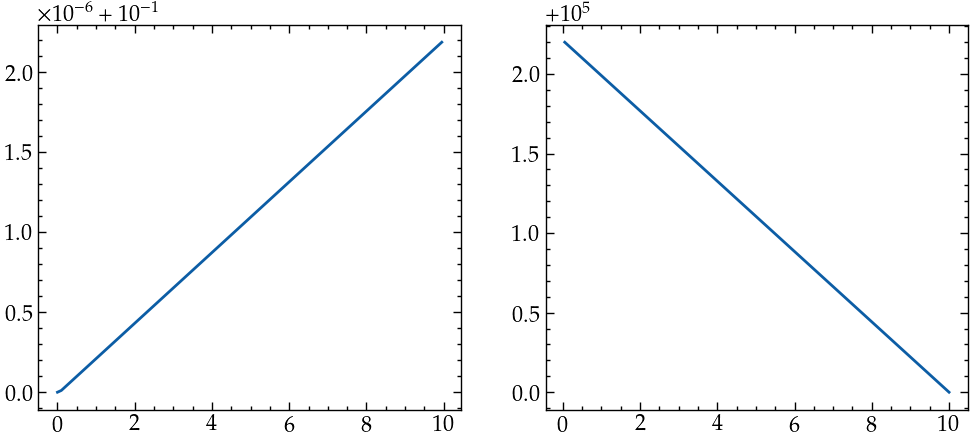

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
z_vec = np.linspace(0.5*dz, L, Nz+1)
zm_vec = np.linspace(0, L-0.5*dz, Nz+1)

axs[0].plot(zm_vec, vzt_mat[:,1])
axs[1].plot(z_vec, pzt_mat[:,1])